## Learning Rate Scheduling

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

### Power Scheduling

### Power Scheduling Formula
Set the learning rate to a function of the iteration number t:

$ η(t) = η_0 / (1 + t/s)^c.$



$lr = lr_0 / (1 + t / s)^c$
* Keras uses `c=1` and `s = 1 / decay` and t=iteration number
* t=current epoch*number of steps per epoch

$lr = lr_0 / (1 + decay*current\ epoch*no\ of\ steps\ per\ epoch)^1$

Here only variable is current epoch


### batch_size=number of samples per gradient upgrade

1.  batch size =integer(default=32)
2. steps_per_epoch=$\frac{number\ of \ training  \ samples}{ batch \ size}$

In [ ]:
no_of_samples=len(X_train_scaled)
default_batch=32
steps=no_of_samples//default_batch
print("\n steps per epoch\n",steps)


 steps per epoch
 1718


In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

## keras documentation model.compile and model.fit

https://keras.io/api/models/model_training_apis/

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4847 - accuracy: 0.8287 - val_loss: 0.4077 - val_accuracy: 0.8608
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3787 - accuracy: 0.8653 - val_loss: 0.3745 - val_accuracy: 0.8690
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3467 - accuracy: 0.8762 - val_loss: 0.3727 - val_accuracy: 0.8690
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3257 - accuracy: 0.8836 - val_loss: 0.3584 - val_accuracy: 0.8740
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3107 - accuracy: 0.8891 - val_loss: 0.3521 - val_accuracy: 0.8778
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2969 - accuracy: 0.8933 - val_loss: 0.3476 - val_accuracy: 0.8790
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2875 - accuracy: 0.8978 - val_loss: 0.3435 - val_accurac

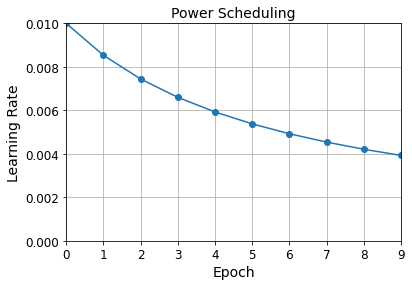

In [ ]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_epochs=10
n_steps_per_epoch = len(X_train_scaled) /batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)
#only variable is epochs
plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Q calculate learning rate at epoch=6?

lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

lrs = 0.01 / (1 + 1e-4 * epochs * 1719)


### Exponential Scheduling

Set the learning rate to

$lr = lr_0 * 0.1**(epoch / s)$


 The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps

## Tensorflow callbacks

https://blog.paperspace.com/tensorflow-callbacks/

https://medium.com/ydata-ai/how-to-use-tensorflow-callbacks-f54f9bb6db25

In [ ]:
# def exponential_decay_fn(epoch):
#     return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 10

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 17s 9ms/step - loss: 0.8756 - accuracy: 0.7530 - val_loss: 0.8145 - val_accuracy: 0.7654 - lr: 0.0100
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6919 - accuracy: 0.7856 - val_loss: 0.6779 - val_accuracy: 0.7786 - lr: 0.0089
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6435 - accuracy: 0.8050 - val_loss: 0.8604 - val_accuracy: 0.7976 - lr: 0.0079
Epoch 4/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5486 - accuracy: 0.8294 - val_loss: 0.5731 - val_accuracy: 0.8230 - lr: 0.0071
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5126 - accuracy: 0.8389 - val_loss: 0.5974 - val_accuracy: 0.8468 - lr: 0.0063
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4721 - accuracy: 0.8503 - val_loss: 0.4999 - val_accuracy: 0.8304 - lr: 0.0056
Epoch 7/10
1719/1719 [=============================

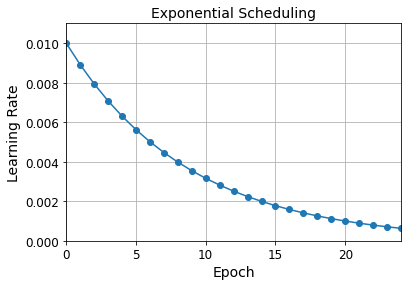

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        #logs to print learning_rate at end of epoch_end
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 10

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.7877 - accuracy: 0.7707 - val_loss: 0.6826 - val_accuracy: 0.7978 - lr: 0.0089
Epoch 2/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.7705 - accuracy: 0.7685 - val_loss: 0.5881 - val_accuracy: 0.8256 - lr: 0.0079
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.6060 - accuracy: 0.8158 - val_loss: 0.6440 - val_accuracy: 0.8198 - lr: 0.0071
Epoch 4/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5565 - accuracy: 0.8315 - val_loss: 0.5645 - val_accuracy: 0.8422 - lr: 0.0063
Epoch 5/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.5044 - accuracy: 0.8462 - val_loss: 0.5164 - val_accuracy: 0.8486 - lr: 0.0056
Epoch 6/10
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4835 - accuracy: 0.8524 - val_loss: 0.5034 - val_accuracy: 0.8520 - lr: 0.0050
Epoch 7/10
1719/1719 [========================

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

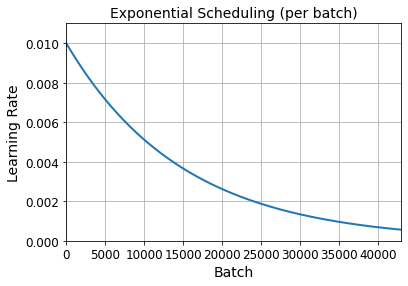

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

1. Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs)

2. then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50epochs), and so on. 

3. Although this solution can work very well, it requires fiddling
around to figure out the right sequence of learning rates and how long to
use each of them.

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8451 - accuracy: 0.7563 - val_loss: 0.8350 - val_accuracy: 0.7668 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.8667 - accuracy: 0.7441 - val_loss: 0.9863 - val_accuracy: 0.6934 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9276 - accuracy: 0.7257 - val_loss: 0.9360 - val_accuracy: 0.6810 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 13s 8ms/step - loss: 1.1115 - accuracy: 0.6216 - val_loss: 1.6973 - val_accuracy: 0.4234 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 1.2477 - accuracy: 0.5797 - val_loss: 1.2056 - val_accuracy: 0.5846 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.9221 - accuracy: 0.6417 - val_loss: 0.9813 - val_accuracy: 0.6400 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

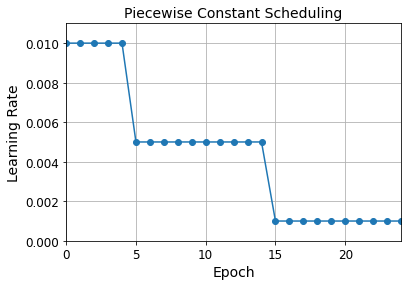

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

Measure the validation error every N steps (just like for early stopping), and
reduce the learning rate by a factor of λ when the error stops dropping.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

1. We will use the following ***callback(reduce learnung rate on  plateau)***
     keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
2. This  will ***multiply the learning rate by 0.5 ***whenever the best ***validation loss does not improve for five consecutive epochs*** (other options are available; please check the documentation for more details)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1719/1719 [==============================] - 8s 4ms/step - loss: 0.5908 - accuracy: 0.8070 - val_loss: 0.4863 - val_accuracy: 0.8474 - lr: 0.0200
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4939 - accuracy: 0.8393 - val_loss: 0.6034 - val_accuracy: 0.8374 - lr: 0.0200
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5016 - accuracy: 0.8439 - val_loss: 0.4986 - val_accuracy: 0.8544 - lr: 0.0200
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5030 - accuracy: 0.8486 - val_loss: 0.5206 - val_accuracy: 0.8588 - lr: 0.0200
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5136 - accuracy: 0.8504 - val_loss: 0.4708 - val_accuracy: 0.8560 - lr: 0.0200
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5028 - accuracy: 0.8559 - val_loss: 0.5840 - val_accuracy: 0.8518 - lr: 0.0200
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step -

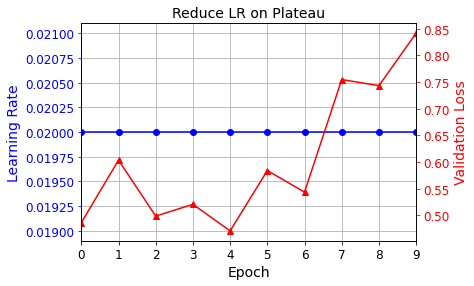

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

1. tf.keras offers an alternative way to implement learning rate scheduling. 
2. define the learning rate using one of the schedules ***available in keras.optimizers.schedules,*** then pass this learning rate to any optimizer. 
3. This approach updates the learning rate at each step rather than at each epoch.

 For example, here is how to implement
the same exponential schedule as the exponential_decay_fn() function we defined

```s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)```
```learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)```
```optimizer = keras.optimizers.SGD(learning_rate)```

This is nice and simple, plus ***when you save the model, the learning rate and its
schedule (including its state) get saved as well***. This approach, however, is not part of the Keras API; it is specific to tf.keras.


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4829 - accuracy: 0.8297 - val_loss: 0.4010 - val_accuracy: 0.8628
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3779 - accuracy: 0.8666 - val_loss: 0.3739 - val_accuracy: 0.8712
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3448 - accuracy: 0.8773 - val_loss: 0.3745 - val_accuracy: 0.8680
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3235 - accuracy: 0.8837 - val_loss: 0.3500 - val_accuracy: 0.8792
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3079 - accuracy: 0.8905 - val_loss: 0.3435 - val_accuracy: 0.8800
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2941 - accuracy: 0.8957 - val_loss: 0.3438 - val_accuracy: 0.8812
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2838 - accuracy: 0.8998 - val_loss: 0.3378 - val_accuracy:

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

1. Contrary to the other approaches, 1cycle (introduced in a 2018 paper21 by Leslie Smith) starts by increasing the initial learning rate ***η0***

2.  growing linearly up to ***η1*** halfway through training. 

3. Then it decreases the learning rate linearly down to*** η0***
again during the second half of training.
4.  finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly).

###Example
 1. The maximum learning rate η1 is chosen using the same approach we used to find the optimallearning rate, and the initial learning rate η0 is chosen to be roughly 10 times lower.
 
2. When using a momentum, we start with a high momentum first (e.g.,0.95),
  
3. then drop it down to a lower momentum during the first half of training(e.g., down to 0.85, linearly), and then bring it back up to the maximum value(e.g., 0.95) during the second half of training,
4. finishing the last few epochs with that maximum value.


 Smith did many experiments showing that this approach
was often able to speed up training considerably and reach better performance.
For example, on the popular CIFAR10 image dataset, this approach reached
91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800
epochs through a standard approach (with the same neural network
architecture).

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/10
5500/5500 [==============================] - 21s 4ms/step - loss: 0.4812 - accuracy: 0.8301 - val_loss: 0.4173 - val_accuracy: 0.8510
Epoch 2/10
5500/5500 [==============================] - 20s 4ms/step - loss: 0.3896 - accuracy: 0.8606 - val_loss: 0.3756 - val_accuracy: 0.8734
Epoch 3/10
5500/5500 [==============================] - 20s 4ms/step - loss: 0.3670 - accuracy: 0.8666 - val_loss: 0.4127 - val_accuracy: 0.8524
Epoch 4/10
5500/5500 [==============================] - 21s 4ms/step - loss: 0.3728 - accuracy: 0.8670 - val_loss: 0.3841 - val_accuracy: 0.8646
Epoch 5/10
5500/5500 [==============================] - 19s 3ms/step - loss: 0.3902 - accuracy: 0.8641 - val_loss: 0.3696 - val_accuracy: 0.8732
Epoch 6/10
5500/5500 [==============================] - 20s 4ms/step - loss: 0.3239 - accuracy: 0.8849 - val_loss: 0.3567 - val_accuracy: 0.8840
Epoch 7/10
5500/5500 [==============================] - 19s 3ms/step - loss: 0.2556 - accuracy: 0.9054 - val_loss: 0.3502 - val_ac

### Exponential learning rate as callback

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

5500/5500 [==============================] - 21s 4ms/step - loss: nan - accuracy: 0.4594


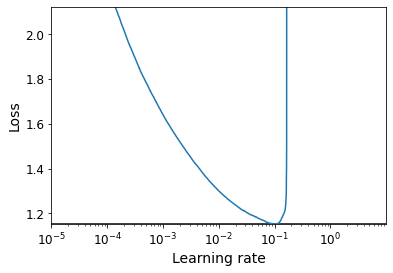

In [ ]:
batch_size = 10
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

# use tensor board

1. before model.fit() use following two commands

  ```logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))```

  ```tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)```

2. pass tensorboard_callback to callbacks argument of model.fit()

  ```
  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])```


3. After model.fit() use following command to display tensorboard

```%tensorboard --logdir logs```



https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [ ]:
n_epochs = 10
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[tensorboard_callback])

%tensorboard --logdir logs

Epoch 1/10
5500/5500 [==============================] - 19s 4ms/step - loss: 0.1162 - accuracy: 0.9595 - val_loss: 0.3169 - val_accuracy: 0.8974
Epoch 2/10
5500/5500 [==============================] - 18s 3ms/step - loss: 0.1162 - accuracy: 0.9595 - val_loss: 0.3168 - val_accuracy: 0.8970
Epoch 3/10
5500/5500 [==============================] - 20s 4ms/step - loss: 0.1161 - accuracy: 0.9596 - val_loss: 0.3168 - val_accuracy: 0.8968
Epoch 4/10
5500/5500 [==============================] - 19s 3ms/step - loss: 0.1161 - accuracy: 0.9596 - val_loss: 0.3168 - val_accuracy: 0.8968
Epoch 5/10
5500/5500 [==============================] - 18s 3ms/step - loss: 0.1160 - accuracy: 0.9596 - val_loss: 0.3168 - val_accuracy: 0.8968
Epoch 6/10
5500/5500 [==============================] - 18s 3ms/step - loss: 0.1160 - accuracy: 0.9596 - val_loss: 0.3168 - val_accuracy: 0.8964
Epoch 7/10
5500/5500 [==============================] - 17s 3ms/step - loss: 0.1160 - accuracy: 0.9597 - val_loss: 0.3168 - val_ac